- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета

In [64]:
import pandas as pd
import numpy as np
data = pd.read_csv("biodeg.csv", sep=";", header=None, names=["SpMax_L", "J_Dz(e)", "nHM", "F01[N-N]", "F04[C-N]", 
                                                              "NssssC", "nCb-", "C%", "nCp", "nO", "F03[C-N]", "SdssC", 
                                                              "HyWi_B(m)", "LOC", "SM6_L", "F03[C-O]", "Me", "Mi", 
                                                              "nN-N", "nArNO2", "nCRX3", "SpPosA_B(p)", "nCIR", 
                                                              "B01[C-Br]", "B03[C-Cl]", "N-073", "SpMax_A", 
                                                              "Psi_i_1d", "B04[C-Br]", "SdO", "TI2_L", "nCrt", 
                                                              "C-026", "F02[C-N]", "nHDon", "SpMax_B(m)", "Psi_i_A",
                                                              "nN", "SM6_B(m)", "nArCOOR", "nX", "biodegradability"])
data.head(3)

,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,...,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,biodegradability
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,RB
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,RB
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,RB


In [65]:
print(data.shape)

(1055, 42)


In [68]:
features = ["SpMax_L", "J_Dz(e)", "nHM", "F01[N-N]", "F04[C-N]",
            "NssssC", "nCb-", "C%", "nCp", "nO", "F03[C-N]", "SdssC", 
            "HyWi_B(m)", "LOC", "SM6_L", "F03[C-O]", "Me", "Mi", 
            "nN-N", "nArNO2", "nCRX3", "SpPosA_B(p)", "nCIR", 
            "B01[C-Br]", "B03[C-Cl]", "N-073", "SpMax_A", 
            "Psi_i_1d", "B04[C-Br]", "SdO", "TI2_L", "nCrt", 
            "C-026", "F02[C-N]", "nHDon", "SpMax_B(m)", "Psi_i_A",
            "nN", "SM6_B(m)", "nArCOOR", "nX"]
target = "biodegradability"

In [69]:
data[target].value_counts()

0    699
1    356
Name: biodegradability, dtype: int64

- сделать feature engineering

In [70]:
data.loc[data[target] == "RB", target] = 1
data.loc[data[target] == "NRB", target] = 0
data[target].value_counts()

0    699
1    356
Name: biodegradability, dtype: int64

- обучить любой классификатор (какой вам нравится)

In [71]:
from sklearn.model_selection import train_test_split

x_data = data[features]
y_data = data[target].astype(int)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=23)

In [72]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(random_state = 23, verbose = False)

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

In [73]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    return f1, roc, rec, prc
    
eval_res = evaluate_results(y_test, y_predict)

Classification results:
f1: 75.50%
roc: 79.96%
recall: 67.06%
precision: 86.36%


- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [74]:
import shap

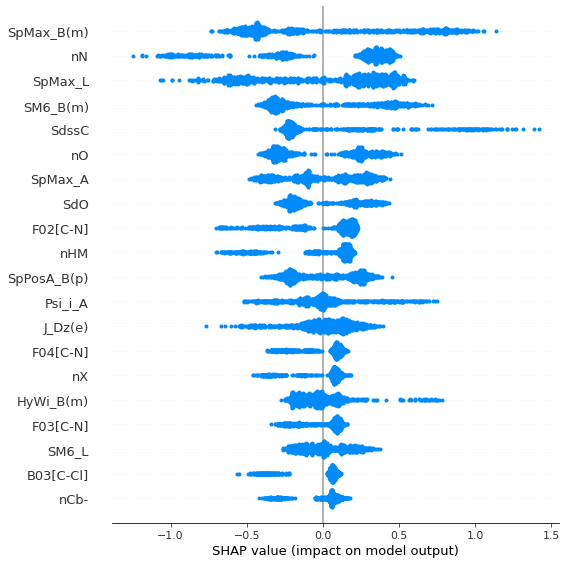

In [76]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, feature_names = features)

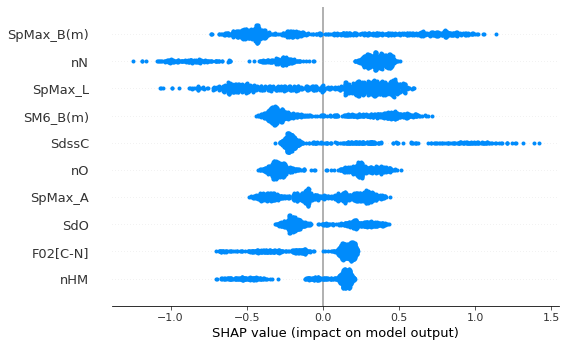

In [77]:
shap.summary_plot(shap_values, feature_names = features, max_display=10)

In [61]:
explainer.expected_value

-1.7133068885125862

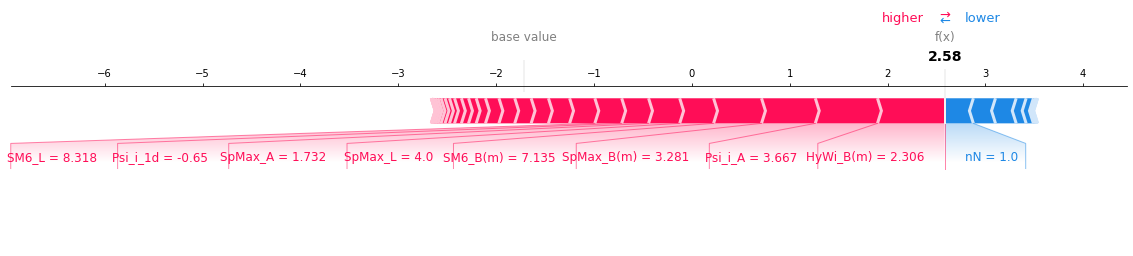

In [62]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:], matplotlib=True)

Интерпретация: не пихайте азот в свои полимеры - он уменьшает биоразложимость материала. 
С другой стороны, лидирующее собственное значение матриц смежности (как взвешенных, так и невзвешенных) является сильным индикатором биоразложимости. Иными словами: молекулы с меньшим числом связей (без кратных связей, бензольных колец и прочих подобных структур) с высокой вероятностью будут более биоразложимы, чем молекулы с большим числом связей.